In [1]:
import sys
import os
import json
import pathlib
import pickle
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

sys.path.append(str(pathlib.Path("../src").resolve().absolute()))
from data import dataset
from models import models as mod
import model_runner

train_file = "../data/raw/topstocks_train.parquet"
valid_file = "../data/raw/topstocks_valid.parquet"
test_file = "../data/raw/topstocks_test.parquet"
supp_file = "../data/raw/topstocks_supplementary.parquet"
train_loader = DataLoader(dataset.StockData(train_file, supp_file, []), batch_size=64)
valid_loader = DataLoader(dataset.StockData(valid_file, supp_file, []), batch_size=64)
test_loader = DataLoader(dataset.StockData(test_file, supp_file, []), batch_size=64)

In [2]:
models = {}
preprocs = {}
results = {}
for config_file in pathlib.Path("../models/config").iterdir():
    config = model_runner.read_model_config(config_file)
    models[config_file.stem] = mod.load_model(config["model"], f"../models/trained/{config_file.stem}.torch")
    preprocs[config_file.stem] = config["data"]["preprocessors"]

    results_file = pathlib.Path(f"../models/trained/{config_file.stem}.torch.loss")
    if results_file.exists():
        with open(results_file, 'rb') as f:
            results[config_file.stem] = pickle.load(f)

def set_preprocs(name):
    train_loader.dataset.preprocessors = preprocs[name]
    valid_loader.dataset.preprocessors = preprocs[name]
    test_loader.dataset.preprocessors = preprocs[name]

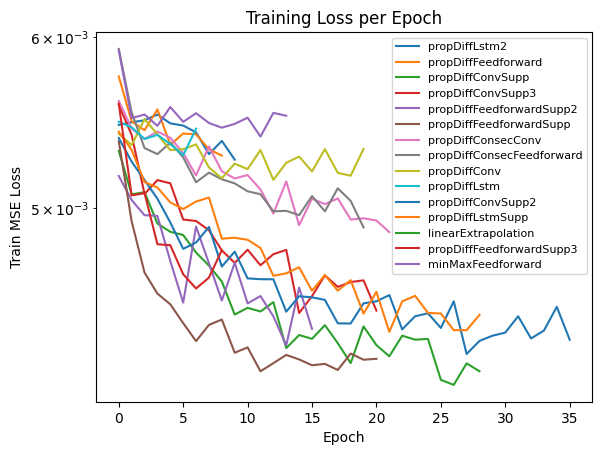

In [3]:
for model, res in results.items():
    if "train" in res:
        plt.plot(range(len(res["train"])), res["train"], label=model)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Train MSE Loss")
plt.title("Training Loss per Epoch")
plt.legend(prop={'size': 8});

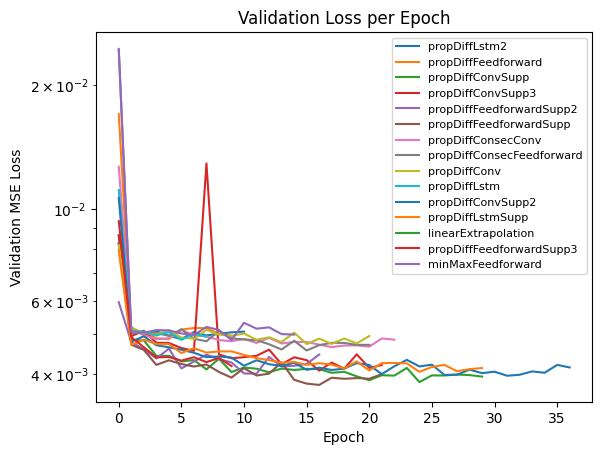

In [4]:
for model, res in results.items():
    if "train" in res:
        plt.plot(range(len(res["valid"])), res["valid"], label=model)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Validation MSE Loss")
plt.title("Validation Loss per Epoch")
plt.legend(prop={'size': 8});

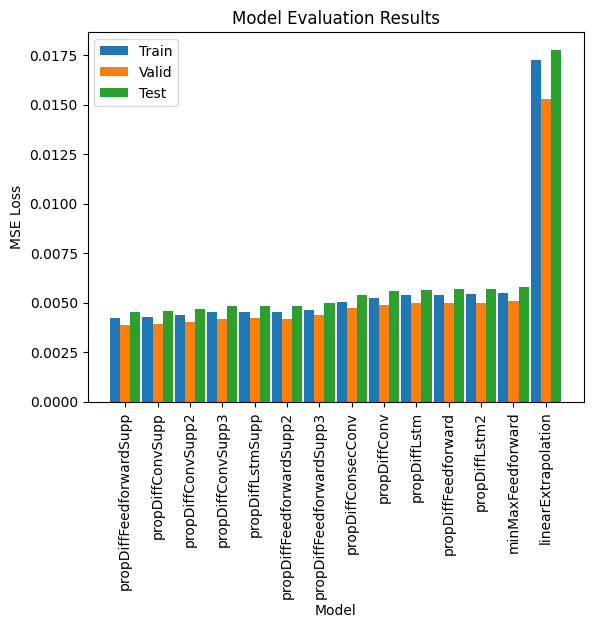

In [5]:
eval_results = pl.DataFrame({"name": [name for name, res in results.items() if "test" in res], 
                              "train": [res["test"]["train"] for _, res in results.items() if "test" in res], 
                              "valid": [res["test"]["valid"] for _, res in results.items() if "test" in res], 
                              "test": [res["test"]["test"] for _, res in results.items() if "test" in res]})

eval_results = eval_results.sort("test")
xs = np.arange(len(eval_results))

plt.bar(xs - 0.3125, eval_results["train"], 0.3125, label='Train')
plt.bar(xs, eval_results["valid"], 0.3125, label='Valid')
plt.bar(xs + 0.3125, eval_results["test"], 0.3125, label='Test')
plt.xticks(xs, eval_results["name"], rotation='vertical')
plt.xlabel("Model") 
plt.ylabel("MSE Loss")
plt.title("Model Evaluation Results") 
plt.legend();

In [6]:
def plot_sample(vis_models, ticker, date):
    row = test_loader.dataset.data.with_row_index().row(by_predicate=(pl.col("ticker") == ticker).and_(pl.col("date") == date))
    idx = test_loader.dataset.offsets.index(row[0])
    test_loader.dataset.preprocessors = [dataset.proportionalDiff("close")]
    ground_truth_in, ground_truth_out, _ = test_loader.dataset[idx]
    plt.plot(range(147), np.concatenate((ground_truth_in[0], ground_truth_out)), label="Ground Truth")
    for model_name in vis_models:
        set_preprocs(model_name)
        input, output, _ = test_loader.dataset[idx]
        input = torch.Tensor(input).unsqueeze(0)
        pred = models[model_name].predict(input)
        plt.plot(range(126, 147), pred[0], label=model_name)

    plt.legend()
    plt.axvline(126, color="black")
    plt.xlabel("Day")
    plt.ylabel("Normalized price")
    plt.title(f"Sample Predictions for {ticker} ({date})")


/tmp/ipykernel_25681/2452244000.py:10: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  input = torch.Tensor(input).unsqueeze(0)


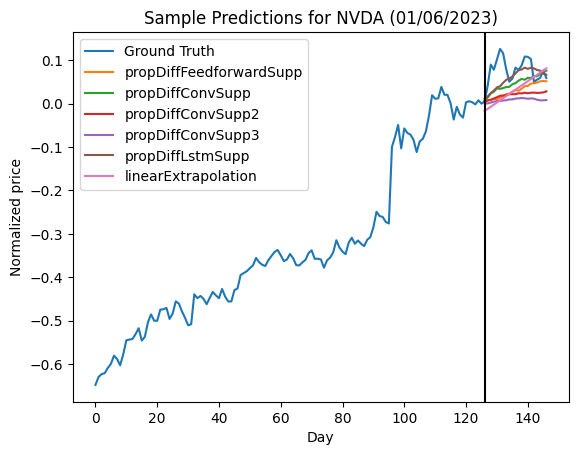

In [7]:
vis_models = eval_results["name"][:5].to_list() + ["linearExtrapolation"]
plot_sample(vis_models, "NVDA", "01/06/2023")

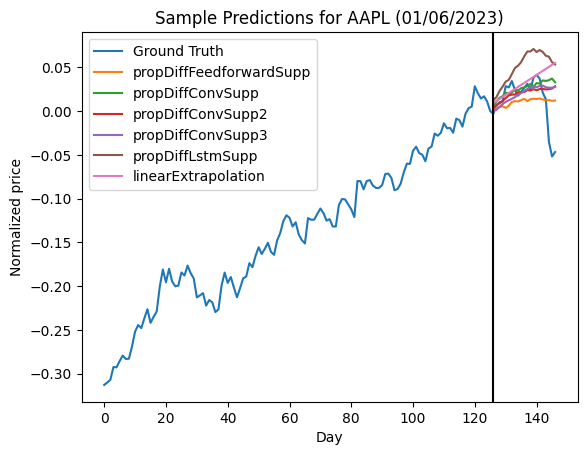

In [8]:
plot_sample(vis_models, "AAPL", "01/06/2023")

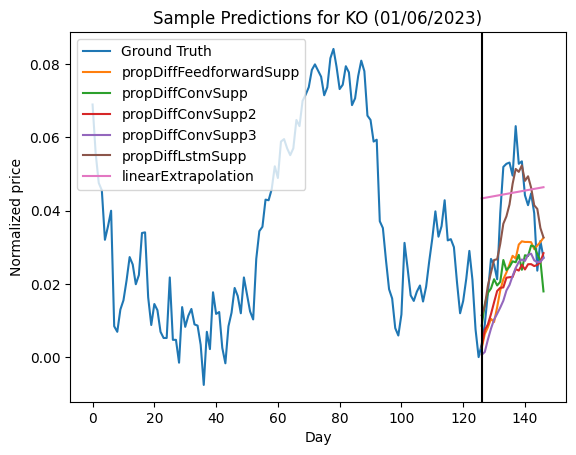

In [9]:
plot_sample(vis_models, "KO", "01/06/2023")

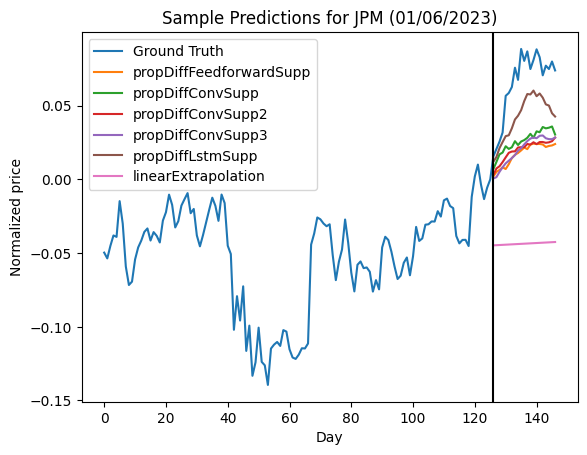

In [10]:
plot_sample(vis_models, "JPM", "01/06/2023")